In [1]:
import sys
sys.path.append('/home/campbell/yulee/DAMM/new/code/pro')

from funcs import *

In [2]:
cohort = 'eddy'
ss = 10
nc = 17

BatchSize = 128
learnRate = 1e-3
nm = 'student'
so = None
rr = 0
rv = 100 
r = 0

In [3]:
analysisProteins = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
       'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
       'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
       'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
       'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS']

pretty_printing = analysisProteins

tr_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_exp.h5ad'.format(cohort, ss))
te_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_exp.h5ad'.format(cohort, ss))

tr_so = torch.load('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_so.zip'.format(cohort, ss))
te_so = torch.load('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_so.zip'.format(cohort, ss))

trY, trS, Theta = prepData(tr_exp, nc, analysisProteins)
trFY, trFS, trFL = simulate_data(trY, trS)

teY, teS, _ = prepData(te_exp, nc, analysisProteins)
teFY, teFS, teFL = simulate_data(teY, teS)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
## get random forest classifier
rf = RandomForestClassifier()
rf.fit(torch.hstack([trFY, trFS.reshape(-1,1)]), trFL)
rf_p_fake_singlet = rf.predict_proba(torch.hstack([teFY, teFS.reshape(-1,1)]))[:,1]
rf_tn, rf_fp, rf_fn, rf_tp, rf_acc, rf_f1, rf_sens, rf_spec = evalM(rf_p_fake_singlet, teFL)
#torch.hstack([teFY, teFS.reshape(-1,1)])

In [5]:
## kmeans mu & psi
mu0 = Theta['log_mu'].exp().detach()
psi0 = Theta['log_psi'].exp().detach()

In [6]:
## get labels
pred_singlet_label, pred_singlet_cluster_assig_label, _ = get_assign_labels(trY, trS, Theta, nm, so, tr_so, rr)

In [7]:
## sorted mu & psi
smu0 = mu0[pd.Series(pred_singlet_cluster_assig_label[0]).value_counts().index]
spsi0 = psi0[pd.Series(pred_singlet_cluster_assig_label[0]).value_counts().index]

# UMAP of Kmeans clusters

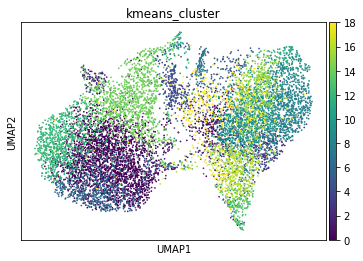

In [8]:
## kmeans cluster
tr_exp.obs['kmeans_cluster'] = smu0.shape[0] + 1
tr_exp.obs.iloc[np.where(pred_singlet_label[0] == 0)[0],-1] = np.array(pred_singlet_cluster_assig_label[0])

sc.pp.neighbors(tr_exp, use_rep='X')
sc.tl.umap(tr_exp)
sc.pl.umap(tr_exp, color="kmeans_cluster")

# Kmeans cluster expressions (sorted)

Text(37.0, 0.5, 'Cluster')

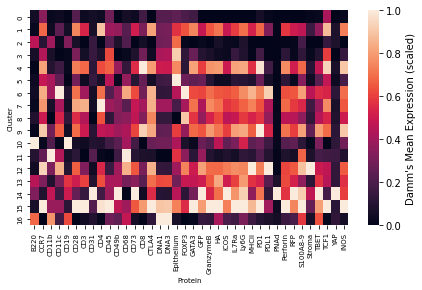

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
s2 = scaler.fit(smu0)
s3 = scaler.transform(smu0)
mat = pd.DataFrame(s3, columns = pretty_printing)

ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Damm's Mean Expression (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 7, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 7, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein", size = 7)
plt.ylabel("Cluster", size = 7)

In [10]:
## doublet probability for each cluster
rf.predict_proba(torch.hstack([smu0, spsi0.reshape(-1,1)]))[:,0] 

array([0.1 , 0.2 , 0.17, 0.12, 0.07, 0.13, 0.21, 0.17, 0.3 , 0.1 , 0.56,
       0.13, 0.12, 0.29, 0.14, 0.14, 0.41])

# Arcsinh (0.1) of cluster expressions

Text(37.0, 0.5, 'Cluster')

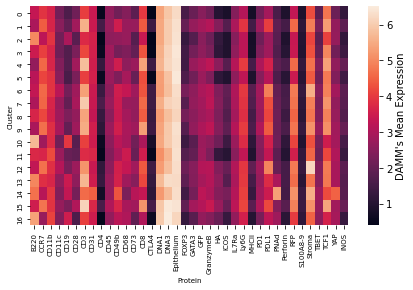

In [11]:
mat = pd.DataFrame(np.arcsinh(np.array(smu0)/0.1), columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expression"})
ax.set_xticklabels(ax.get_xticklabels(), size = 7, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 7, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein", size = 7)
plt.ylabel("Cluster", size = 7)

# Cell sizes in each cluster (Kmeans)

<AxesSubplot:xlabel='cluster', ylabel='size'>

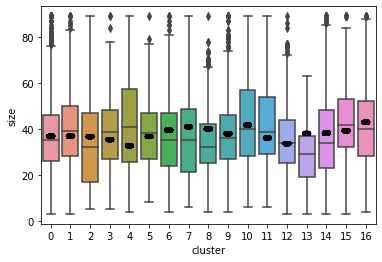

In [12]:
d1 = pd.DataFrame({'cluster': range(smu0.shape[0]), 'psi': spsi0})
d2 = pd.DataFrame({'size': trS[pred_singlet_label[0] == 0], 
                   'cluster': np.array(pred_singlet_cluster_assig_label[0].detach())})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

# Correlation

In [13]:
df_corr = pd.DataFrame(np.array(smu0), columns = pretty_printing).corr()
print("correlation between CD45 vs CD4:           {}".format(df_corr.loc['CD45','CD4']))
print("correlation between CD45 vs CD8:           {}".format(df_corr.loc['CD45','CD8']))
print("correlation between CD45 vs CD11b:         {}".format(df_corr.loc['CD45','CD11b']))
print("correlation between CD45 vs CD19:          {}".format(df_corr.loc['CD45','CD19']))
print("correlation between CD45 vs CD28:          {}".format(df_corr.loc['CD45','CD28']))
print("correlation between CD45 vs CD68:          {}".format(df_corr.loc['CD45','CD68']))

print("correlation between CD4 vs CD8:            {}".format(df_corr.loc['CD4','CD8']))
print("correlation between CD4 vs CD28:           {}".format(df_corr.loc['CD4','CD28']))
print("correlation between CD8 vs CD28:           {}".format(df_corr.loc['CD8','CD28']))

print("correlation between Stroma vs CD31:        {}".format(df_corr.loc['Stroma','CD31']))
print("correlation between Stroma vs Epithelium:  {}".format(df_corr.loc['Stroma','Epithelium']))

print("correlation between Epithelium vs CD4:     {}".format(df_corr.loc['Epithelium','CD4']))
print("correlation between Epithelium vs CD8:     {}".format(df_corr.loc['Epithelium','CD8']))
print("correlation between Epithelium vs CD11b:   {}".format(df_corr.loc['Epithelium','CD11b']))
print("correlation between Epithelium vs CD31:    {}".format(df_corr.loc['Epithelium','CD31']))
print("correlation between Epithelium vs CD19:    {}".format(df_corr.loc['Epithelium','CD19']))
print("correlation between Epithelium vs CD45:    {}".format(df_corr.loc['Epithelium','CD45']))

correlation between CD45 vs CD4:           0.3920655071111438
correlation between CD45 vs CD8:           0.6590196541373493
correlation between CD45 vs CD11b:         -0.2758331579393415
correlation between CD45 vs CD19:          -0.23099841527514461
correlation between CD45 vs CD28:          0.5272762578695177
correlation between CD45 vs CD68:          -0.47163675372905406
correlation between CD4 vs CD8:            0.5857985853836223
correlation between CD4 vs CD28:           0.9393136543251591
correlation between CD8 vs CD28:           0.7626354819397839
correlation between Stroma vs CD31:        0.19601736950146267
correlation between Stroma vs Epithelium:  -0.11638952853391636
correlation between Epithelium vs CD4:     -0.1598207114478046
correlation between Epithelium vs CD8:     0.31423398861054536
correlation between Epithelium vs CD11b:   0.07527236324926388
correlation between Epithelium vs CD31:    0.14765853090034572
correlation between Epithelium vs CD19:    -0.331811933208

In [14]:
## run DAMM
loss, Theta = trainWFD(ConcatDataset(trY, trS, trFY, trFS, trFL), Theta, BatchSize, nm, learnRate, rv, so, tr_so, rr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


# Loss Function

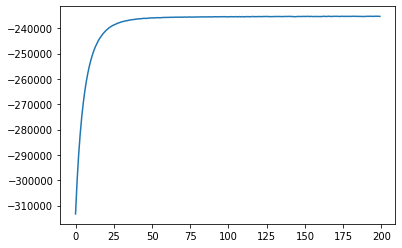

In [15]:
## total loss
plt.plot(np.array(loss)[:,0])

In [16]:
with torch.no_grad():
    ## watch out for when input matrix are big!!
    _, _, _ , damm_p_fake_singlet = compute_posteriors_nll_p_singlet(teFY, teFS, Theta, nm, so, te_so, rr)
    
    tn, fp, fn, tp, acc, f1, sens, spec = evalM(damm_p_fake_singlet, teFL)
    cor2 = np.corrcoef(damm_p_fake_singlet, rf_p_fake_singlet)

    iter_out = [nc, nm, rv, so, rr, r, len(np.where(damm_p_fake_singlet > 0.5)[0]), tn, fp, fn, tp, acc, f1, sens, spec, 
            len(np.where(rf_p_fake_singlet > 0.5)[0]), rf_tn, rf_fp, rf_fn, rf_tp, rf_acc, rf_f1, rf_sens, rf_spec, cor2[0,1]]

    output_pred_doublet = pd.Series(iter_out) #.to_csv(output_pred_doublet)

In [17]:
## damm mu & psi
mu1 = Theta['log_mu'].exp().detach()
psi1 = Theta['log_psi'].exp().detach()

In [18]:
## get labels
pred_singlet_label, pred_singlet_cluster_assig_label, _ = get_assign_labels(trY, trS, Theta, nm, so, tr_so, rr)

In [19]:
## sorted mu & psi
smu1 = mu1[pd.Series(pred_singlet_cluster_assig_label[0]).value_counts().index]
spsi1 = psi1[pd.Series(pred_singlet_cluster_assig_label[0]).value_counts().index]

# UMAP of DAMM clusters

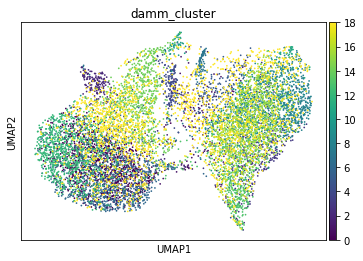

In [20]:
## damm cluster
tr_exp.obs['damm_cluster'] = smu1.shape[0] + 1
tr_exp.obs.iloc[np.where(pred_singlet_label[0] == 0)[0],-1] = np.array(pred_singlet_cluster_assig_label[0])

sc.pl.umap(tr_exp, color="damm_cluster")

# DAMM's cluster expressions

Text(37.0, 0.5, 'Cluster')

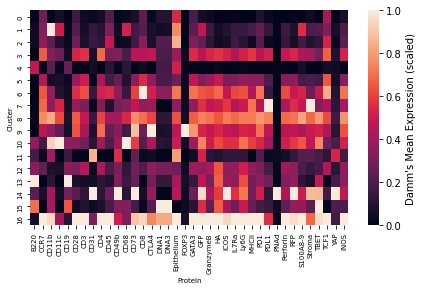

In [21]:
scaler = MinMaxScaler()
s2 = scaler.fit(smu1)
s3 = scaler.transform(smu1)
mat = pd.DataFrame(s3, columns = pretty_printing)

ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Damm's Mean Expression (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 7, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 7, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein", size = 7)
plt.ylabel("Cluster", size = 7)

In [22]:
## doublet probability for each cluster
rf.predict_proba(torch.hstack([smu1, spsi1.reshape(-1,1)]))[:,0]

array([0.1 , 0.13, 0.14, 0.05, 0.08, 0.13, 0.04, 0.06, 0.11, 0.07, 0.18,
       0.16, 0.11, 0.1 , 0.05, 0.09, 0.04])

# Arcsinh (0.1) version

Text(37.0, 0.5, 'Cluster')

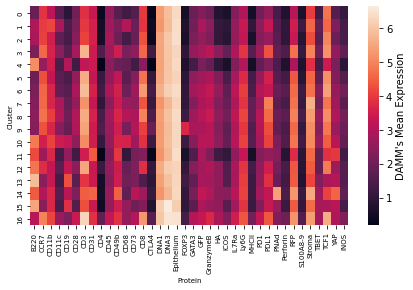

In [23]:
mat = pd.DataFrame(np.arcsinh(np.array(smu1)/0.1), columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expression"})
ax.set_xticklabels(ax.get_xticklabels(), size = 7, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 7, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein", size = 7)
plt.ylabel("Cluster", size = 7)

# Cell sizes in each cluster (DAMM)

<AxesSubplot:xlabel='cluster', ylabel='size'>

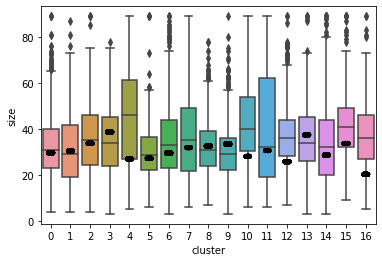

In [24]:
d1 = pd.DataFrame({'cluster': range(smu1.shape[0]), 'psi': spsi1})
d2 = pd.DataFrame({'size': trS[pred_singlet_label[0] == 0], 
                   'cluster': np.array(pred_singlet_cluster_assig_label[0].detach())})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

In [25]:
df_corr = pd.DataFrame(np.array(smu1), columns = pretty_printing).corr()
print("correlation between CD45 vs CD4:           {}".format(df_corr.loc['CD45','CD4']))
print("correlation between CD45 vs CD8:           {}".format(df_corr.loc['CD45','CD8']))
print("correlation between CD45 vs CD11b:         {}".format(df_corr.loc['CD45','CD11b']))
print("correlation between CD45 vs CD19:          {}".format(df_corr.loc['CD45','CD19']))
print("correlation between CD45 vs CD28:          {}".format(df_corr.loc['CD45','CD28']))
print("correlation between CD45 vs CD68:          {}".format(df_corr.loc['CD45','CD68']))

print("correlation between CD4 vs CD8:            {}".format(df_corr.loc['CD4','CD8']))
print("correlation between CD4 vs CD28:           {}".format(df_corr.loc['CD4','CD28']))
print("correlation between CD8 vs CD28:           {}".format(df_corr.loc['CD8','CD28']))

print("correlation between Stroma vs CD31:        {}".format(df_corr.loc['Stroma','CD31']))
print("correlation between Stroma vs Epithelium:  {}".format(df_corr.loc['Stroma','Epithelium']))

print("correlation between Epithelium vs CD4:     {}".format(df_corr.loc['Epithelium','CD4']))
print("correlation between Epithelium vs CD8:     {}".format(df_corr.loc['Epithelium','CD8']))
print("correlation between Epithelium vs CD11b:   {}".format(df_corr.loc['Epithelium','CD11b']))
print("correlation between Epithelium vs CD31:    {}".format(df_corr.loc['Epithelium','CD31']))
print("correlation between Epithelium vs CD19:    {}".format(df_corr.loc['Epithelium','CD19']))
print("correlation between Epithelium vs CD45:    {}".format(df_corr.loc['Epithelium','CD45']))

correlation between CD45 vs CD4:           0.6579272254215652
correlation between CD45 vs CD8:           0.7788815661746605
correlation between CD45 vs CD11b:         0.4688083752492302
correlation between CD45 vs CD19:          -0.3411198712176903
correlation between CD45 vs CD28:          0.7844756282542207
correlation between CD45 vs CD68:          0.10044929888731445
correlation between CD4 vs CD8:            0.7623039756924614
correlation between CD4 vs CD28:           0.957298926570786
correlation between CD8 vs CD28:           0.843517085492295
correlation between Stroma vs CD31:        0.33703948602970396
correlation between Stroma vs Epithelium:  0.034180606162137604
correlation between Epithelium vs CD4:     0.18871094161041366
correlation between Epithelium vs CD8:     0.43469554941647126
correlation between Epithelium vs CD11b:   0.4580378666998533
correlation between Epithelium vs CD31:    0.340599173751616
correlation between Epithelium vs CD19:    -0.44619703294824187
co

# DAMM doublet probability

In [26]:
with torch.no_grad():
    _, _, _, p_singlet = compute_posteriors_nll_p_singlet(trY, trS, Theta, nm, so, tr_so, rr)

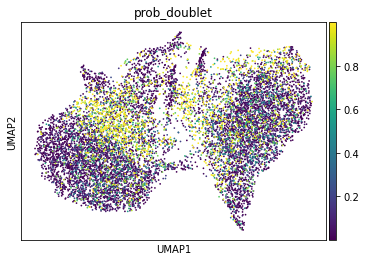

In [27]:
tr_exp.obs['prob_doublet'] = 1 - np.array(p_singlet.detach())
sc.pl.umap(tr_exp, color="prob_doublet")

# PhenoGraph cluster expressions

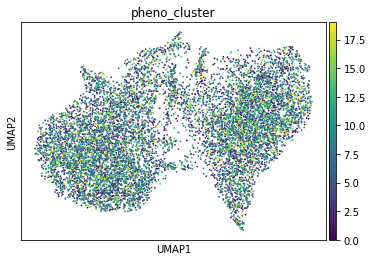

In [28]:
pheno = pd.read_csv('/home/campbell/yulee/DAMM/new/res/basel/10k/pheno/model/phenograph_assignments_30_0.csv')
tr_exp.obs['pheno_cluster'] = np.array(np.array(pheno)[:,1])
sc.pl.umap(tr_exp, color="pheno_cluster")

In [29]:
'''
Make a umap of the basel and eddy data, and colour by
Kmeans cluster
Damm cluster
Phenograph cluster
p(doublet)
'''

'\nMake a umap of the basel and eddy data, and colour by\nKmeans cluster\nDamm cluster\nPhenograph cluster\np(doublet)\n'